In [1]:
%pip install transformers datasets -q

In [2]:
!git clone https://github.com/martingrzzler/robanohashi-thesis-notebook.git

Cloning into 'robanohashi-thesis-notebook'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 49 (delta 21), reused 38 (delta 10), pack-reused 0
Unpacking objects: 100% (49/49), 335.20 KiB | 813.00 KiB/s, done.


In [3]:
%cd robanohashi-thesis-notebook

/content/robanohashi-thesis-notebook


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-phrase-word-concreteness')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [4]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
sample = ds['train'][10]
sample

{'kanji_id': 1929,
 'component_meanings': 'canopy,tree,stone',
 'wanikani_mnemonic': "Below this <radical>canopy</radical> of <radical>tree</radical>s is a <radical>stone</radical>. Since it's the only stone here, you make sure to <kanji>polish</kanji> it. It's a single, perfectly round stone under this canopy of trees. It didn't start this way, but thanks to all the polishing you did, it has become nice and smooth.",
 'kanji_meaning': 'polish',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form\n tree canopy of the stone circle at Stonehenge by polisharchitecture on Flickr, used under Creative Commons license (CC BY-NC) This interview has been edited for length and clarity The following are excerpts from an hourlong conversation between Democracy Now!'s Amy Goodman",
 'gpt3_paragraph': 'The canopy of the tree was so lush and inviting that it seemed to be calling out to me. I stepped closer and noticed a smooth stone beneath my feet, as if it had been pol

In [12]:
from nltk.tokenize import sent_tokenize
import re

def tokenize(text):
    text = re.sub('<.*?>', '', text)
    sents = sent_tokenize(text)

    return sents

In [6]:
def predict_phrase(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=50)
    inputs.to(device)
    outputs = model(**inputs)
    return outputs.logits.item()

In [20]:
t = tokenize(sample['wanikani_mnemonic'])
predict_phrase(t[3])

0.263240247964859

In [21]:
def mean_sentence_concreteness(text):
    sentences = tokenize(text)
    return sum([predict_phrase(s) for s in sentences])/len(sentences)

In [22]:
mean_sentence_concreteness(sample['wanikani_mnemonic'])

0.28035153448581696

In [23]:
def map_mean_sentence_concreteness(bar=None):
    def func(example):
        example['gpt3_paragraph_concreteness'] = mean_sentence_concreteness(example['gpt3_paragraph'])
        example['gpt3_mnemonic_concreteness'] = mean_sentence_concreteness(example['gpt3_mnemonic'])
        example['wanikani_concreteness'] = mean_sentence_concreteness(example['wanikani_mnemonic'])
        example['gpt2xl_concreteness'] = mean_sentence_concreteness(example['gpt2xl_mnemonic'])
        if bar is not None:
            bar.update(1)
        return example
    return func

In [24]:
map_mean_sentence_concreteness()(sample)

{'kanji_id': 1929,
 'component_meanings': 'canopy,tree,stone',
 'wanikani_mnemonic': "Below this <radical>canopy</radical> of <radical>tree</radical>s is a <radical>stone</radical>. Since it's the only stone here, you make sure to <kanji>polish</kanji> it. It's a single, perfectly round stone under this canopy of trees. It didn't start this way, but thanks to all the polishing you did, it has become nice and smooth.",
 'kanji_meaning': 'polish',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form\n tree canopy of the stone circle at Stonehenge by polisharchitecture on Flickr, used under Creative Commons license (CC BY-NC) This interview has been edited for length and clarity The following are excerpts from an hourlong conversation between Democracy Now!'s Amy Goodman",
 'gpt3_paragraph': 'The canopy of the tree was so lush and inviting that it seemed to be calling out to me. I stepped closer and noticed a smooth stone beneath my feet, as if it had been pol

In [25]:
from tqdm.auto import tqdm

bar = tqdm(total=len(ds['train']))

ds_sent_concreteness = ds.map(map_mean_sentence_concreteness(bar=bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [26]:
ds_sent_concreteness['train'][10]

{'kanji_id': 1929,
 'component_meanings': 'canopy,tree,stone',
 'wanikani_mnemonic': "Below this <radical>canopy</radical> of <radical>tree</radical>s is a <radical>stone</radical>. Since it's the only stone here, you make sure to <kanji>polish</kanji> it. It's a single, perfectly round stone under this canopy of trees. It didn't start this way, but thanks to all the polishing you did, it has become nice and smooth.",
 'kanji_meaning': 'polish',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form\n tree canopy of the stone circle at Stonehenge by polisharchitecture on Flickr, used under Creative Commons license (CC BY-NC) This interview has been edited for length and clarity The following are excerpts from an hourlong conversation between Democracy Now!'s Amy Goodman",
 'gpt3_paragraph': 'The canopy of the tree was so lush and inviting that it seemed to be calling out to me. I stepped closer and noticed a smooth stone beneath my feet, as if it had been pol

In [27]:
from scipy.stats import f_oneway

f, p = f_oneway(ds_sent_concreteness['train']['gpt3_paragraph_concreteness'], ds_sent_concreteness['train']['gpt3_mnemonic_concreteness'], ds_sent_concreteness['train']['wanikani_concreteness'], ds_sent_concreteness['train']['gpt2xl_concreteness'])
print(f"p-value: {p}")

p-value: 8.39754171471735e-36


In [46]:
import matplotlib.pyplot as plt

def box_plot(df, title):
    fig, ax = plt.subplots(1,1)
    ax.boxplot([df['gpt3_paragraph_concreteness'], df['gpt3_mnemonic_concreteness'], df['wanikani_concreteness'], df['gpt2xl_concreteness']])
    ax.set_xticklabels(['GPT-3 Paragraph', 'GPT-3 Mnemonic', 'WaniKani', 'GPT-2XL'])
    ax.set_title(title)
    plt.show()
   

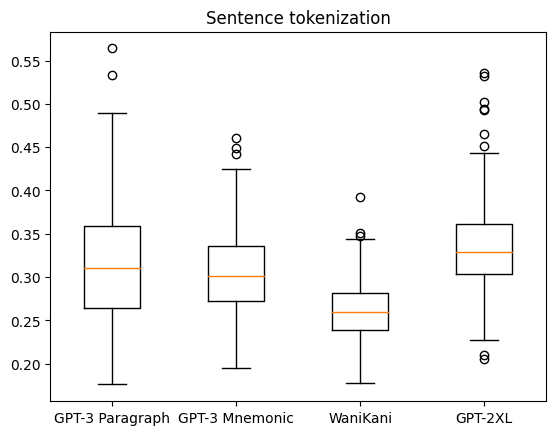

In [31]:
box_plot(ds_sent_concreteness['train'], 'Sentence tokenization')

In [43]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text)
    doc = nlp(text)
    chunks = []
    for chunk in doc.noun_chunks:
        chunks.append(chunk.text)
    return chunks

In [45]:
tokenize(sample['gpt3_mnemonic'])

['a time',
 'a canopy',
 'trees',
 'that',
 'the horizon',
 'the canopy',
 'a large stone',
 'the stone',
 'it',
 'it',
 'it',
 'the sunlight',
 'the canopy',
 'trees']

In [46]:
def mean_noun_chunk_concreteness(text):
    chunks = tokenize(text)
    return sum([predict_phrase(c) for c in chunks])/len(chunks)

In [47]:
def map_mean_noun_chunk_concreteness(bar=None):
    def func(example):
        example['gpt3_paragraph_concreteness'] = mean_noun_chunk_concreteness(example['gpt3_paragraph'])
        example['gpt3_mnemonic_concreteness'] = mean_noun_chunk_concreteness(example['gpt3_mnemonic'])
        example['wanikani_concreteness'] = mean_noun_chunk_concreteness(example['wanikani_mnemonic'])
        example['gpt2xl_concreteness'] = mean_noun_chunk_concreteness(example['gpt2xl_mnemonic'])
        if bar is not None:
            bar.update(1)
        return example
    return func

In [48]:
bar = tqdm(total=len(ds['train']))
ds_noun_chunk_concr = ds.map(map_mean_noun_chunk_concreteness(bar=bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [7]:
def anova(df):
    f, p = f_oneway(df['gpt3_paragraph_concreteness'], df['gpt3_mnemonic_concreteness'], df['wanikani_concreteness'], df['gpt2xl_concreteness'])
    print(f"p-value: {p}")

In [50]:
anova(ds_noun_chunk_concr['train'])

p-value: 1.2072112779120135e-09


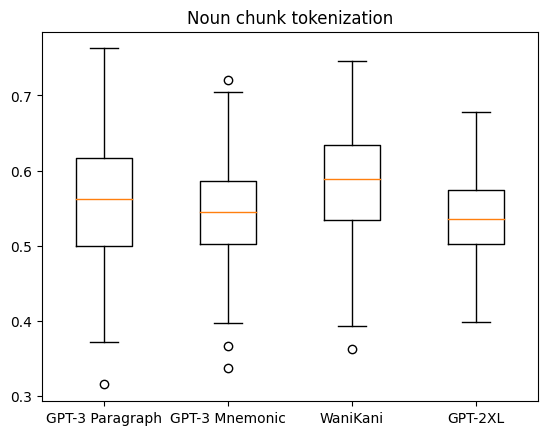

In [51]:
box_plot(ds_noun_chunk_concr['train'], 'Noun chunk tokenization')

In [52]:
def tokenize(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text)
    doc = nlp(text)
    chunks = []
    for chunk in doc.noun_chunks:
        chunks.append(chunk.text)


    return chunks

In [8]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')

In [9]:
def tokenize(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text)
    doc = nlp(text)
    chunks = []
    idx = 0

    for chunk in doc.noun_chunks:
        # Append text between chunks
        if idx < chunk.start:
            chunks.append(doc[idx:chunk.start].text)
        # Append chunk text
        chunks.append(chunk.text)
        idx = chunk.end

    # Append remaining text after the last chunk
    if idx < len(doc):
        chunks.append(doc[idx:].text)

    return chunks

In [60]:
sentence = "A blue horse took his gun and shot at the bank official"
tokenize(sentence)

['a blue horse', 'took', 'his gun', 'and shot at', 'the bank official']

In [17]:
def mean_chunk_concreteness(text):
    chunks = tokenize(text)
    return sum([predict_phrase(c) for c in chunks])/len(chunks)

In [18]:
def map_mean_chunk_concreteness(bar=None):
    def func(example):
        example['gpt3_paragraph_concreteness'] = mean_chunk_concreteness(example['gpt3_paragraph'])
        example['gpt3_mnemonic_concreteness'] = mean_chunk_concreteness(example['gpt3_mnemonic'])
        example['wanikani_concreteness'] = mean_chunk_concreteness(example['wanikani_mnemonic'])
        example['gpt2xl_concreteness'] = mean_chunk_concreteness(example['gpt2xl_mnemonic'])
        if bar is not None:
            bar.update(1)
        return example
    return func

In [61]:
bar = tqdm(total=len(ds['train']))
ds_chunk_concr = ds.map(map_mean_chunk_concreteness(bar=bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [62]:
anova(ds_chunk_concr['train'])

p-value: 1.768747202841411e-05


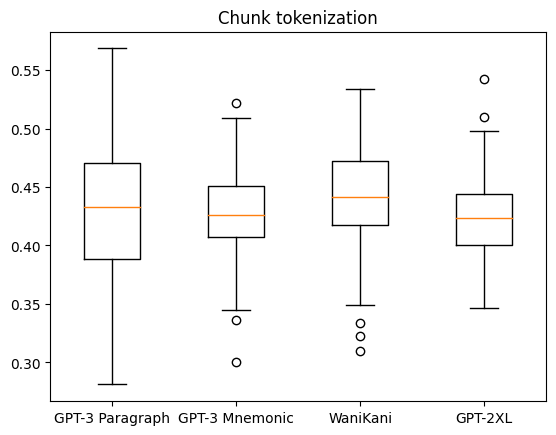

In [63]:
box_plot(ds_chunk_concr['train'], 'Chunk tokenization')

In [11]:
from scipy.stats import tukey_hsd

def tukey(df):
    res = tukey_hsd(df['gpt3_paragraph_concreteness'], df['gpt3_mnemonic_concreteness'], df['wanikani_concreteness'], df['gpt2xl_concreteness'])
    print(res)

In [65]:
tukey(ds_chunk_concr['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.006     0.582    -0.006     0.017
 (0 - 2)     -0.011     0.046    -0.022    -0.000
 (0 - 3)      0.009     0.164    -0.002     0.020
 (1 - 0)     -0.006     0.582    -0.017     0.006
 (1 - 2)     -0.017     0.001    -0.028    -0.006
 (1 - 3)      0.003     0.854    -0.008     0.015
 (2 - 0)      0.011     0.046     0.000     0.022
 (2 - 1)      0.017     0.001     0.006     0.028
 (2 - 3)      0.020     0.000     0.009     0.031
 (3 - 0)     -0.009     0.164    -0.020     0.002
 (3 - 1)     -0.003     0.854    -0.015     0.008
 (3 - 2)     -0.020     0.000    -0.031    -0.009



In [12]:
def max_n_chunk_concreteness(text, n = 3):
    chunks = tokenize(text)
    scores = [predict_phrase(c) for c in chunks]
    sorted_scores = sorted(scores, reverse=True)

    if len(sorted_scores) < n:
        return sum(sorted_scores)/len(sorted_scores)

    return sum(sorted_scores[:n])/n

In [34]:
def map_max_n_chunk_concreteness(bar=None, n=3):
    def func(example):
        example['gpt3_paragraph_concreteness'] = max_n_chunk_concreteness(example['gpt3_paragraph'], n=n)
        example['gpt3_mnemonic_concreteness'] = max_n_chunk_concreteness(example['gpt3_mnemonic'], n=n)
        example['wanikani_concreteness'] = max_n_chunk_concreteness(example['wanikani_mnemonic'], n=n)
        example['gpt2xl_concreteness'] = max_n_chunk_concreteness(example['gpt2xl_mnemonic'], n=n)
        if bar is not None:
            bar.update(1)
        return example
    return func

In [14]:
from tqdm.auto import tqdm

In [15]:
bar = tqdm(total=len(ds['train']))
ds_chunk_max_concr = ds.map(map_max_n_chunk_concreteness(bar=bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [69]:
anova(ds_chunk_max_concr['train'])

p-value: 1.3144758158773e-09


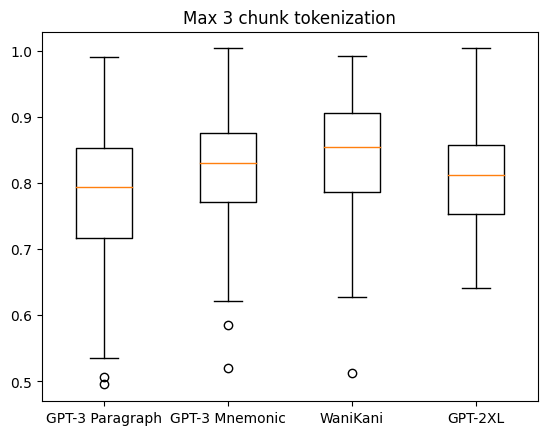

In [70]:
box_plot(ds_chunk_max_concr['train'], 'Max 3 chunk tokenization')

In [71]:
tukey(ds_chunk_max_concr['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.036     0.000    -0.059    -0.013
 (0 - 2)     -0.058     0.000    -0.081    -0.035
 (0 - 3)     -0.024     0.028    -0.047    -0.002
 (1 - 0)      0.036     0.000     0.013     0.059
 (1 - 2)     -0.022     0.058    -0.045     0.001
 (1 - 3)      0.012     0.553    -0.011     0.034
 (2 - 0)      0.058     0.000     0.035     0.081
 (2 - 1)      0.022     0.058    -0.001     0.045
 (2 - 3)      0.034     0.001     0.011     0.056
 (3 - 0)      0.024     0.028     0.002     0.047
 (3 - 1)     -0.012     0.553    -0.034     0.011
 (3 - 2)     -0.034     0.001    -0.056    -0.011



In [37]:
def chunk_concreteness_scores(text):
    chunks = tokenize(text)
    scores = [predict_phrase(c) for c in chunks]
    sorted_scores = sorted(scores, reverse=True)
    return sorted_scores

In [38]:
def map_chunk_concreteness_scores(bar=None):
    def func(example):
        example['gpt3_paragraph_concreteness_scores'] = chunk_concreteness_scores(example['gpt3_paragraph'])
        example['gpt3_mnemonic_concreteness_scores'] = chunk_concreteness_scores(example['gpt3_mnemonic'])
        example['wanikani_concreteness_scores'] = chunk_concreteness_scores(example['wanikani_mnemonic'])
        example['gpt2xl_concreteness_scores'] = chunk_concreteness_scores(example['gpt2xl_mnemonic'])
        if bar is not None:
            bar.update(1)
        return example
    return func

In [39]:
bar = tqdm(total=len(ds['train']))
ds_chunk_scores = ds.map(map_chunk_concreteness_scores(bar=bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [42]:
def n_mean(scores, n=3):
    if len(scores) < n:
        return sum(scores)/len(scores)
    return sum(scores[:n])/n

def map_mean_max_n_score(n=3):
    def func(example):
        example['gpt3_paragraph_concreteness'] = n_mean(example['gpt3_paragraph_concreteness_scores'], n=n)
        example['gpt3_mnemonic_concreteness'] = n_mean(example['gpt3_mnemonic_concreteness_scores'], n=n)
        example['wanikani_concreteness'] = n_mean(example['wanikani_concreteness_scores'], n=n)
        example['gpt2xl_concreteness'] = n_mean(example['gpt2xl_concreteness_scores'], n=n)
        return example
    return func


In [43]:
ds_3_mean = ds_chunk_scores.map(map_mean_max_n_score(3))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

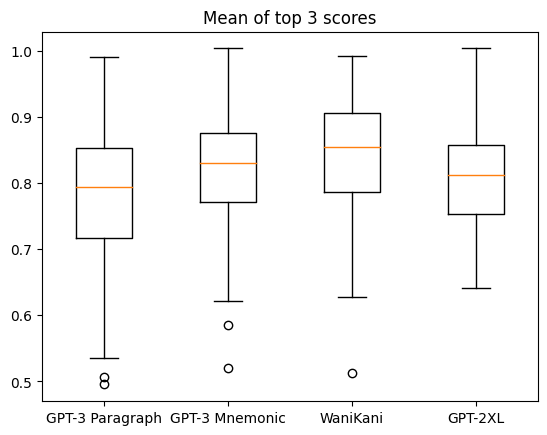

In [47]:
box_plot(ds_3_mean['train'], 'Mean of top 3 scores')

In [76]:
from scipy.stats import f_oneway

def p(ds):
    f, p = f_oneway(ds['gpt3_paragraph_concreteness'], ds['gpt3_mnemonic_concreteness'], ds['wanikani_concreteness'], ds['gpt2xl_concreteness'])
    return p

p_values = []
n_range = range(1, 80)

for n in n_range:
    ds_n_mean = ds_chunk_scores.map(map_mean_max_n_score(n))
    p_values.append(p(ds_n_mean['train']))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

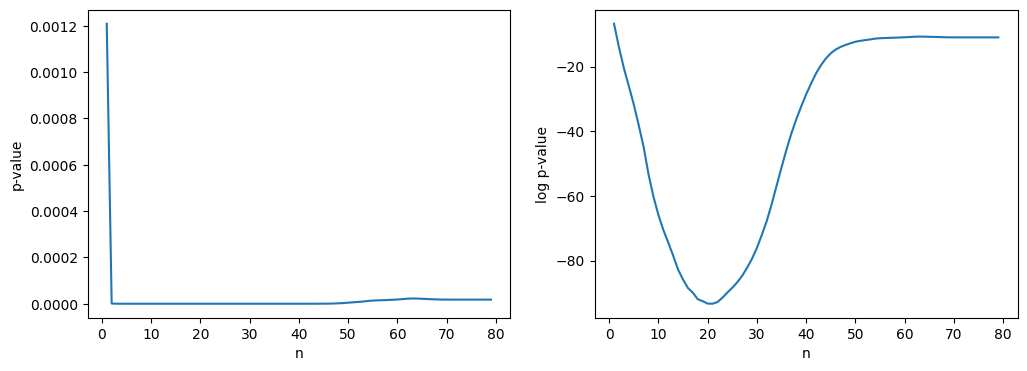

In [77]:
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(n_range, p_values)
ax[0].set_xlabel('n')
ax[0].set_ylabel('p-value')

ax[1].plot(n_range, np.log(p_values))
ax[1].set_xlabel('n')
ax[1].set_ylabel('log p-value')

plt.show()


In [62]:
ds_20_mean = ds_chunk_scores.map(map_mean_max_n_score(20))

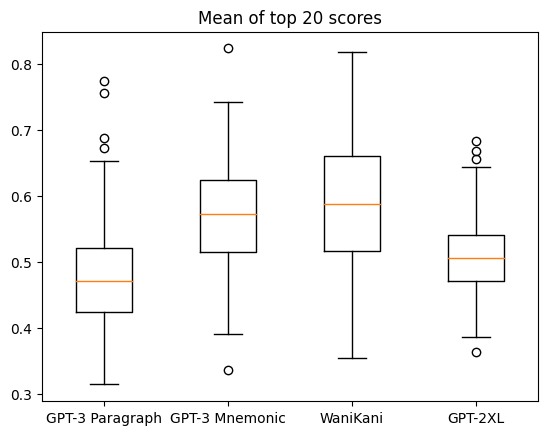

In [63]:
box_plot(ds_20_mean['train'], 'Mean of top 20 scores')

<Axes: >

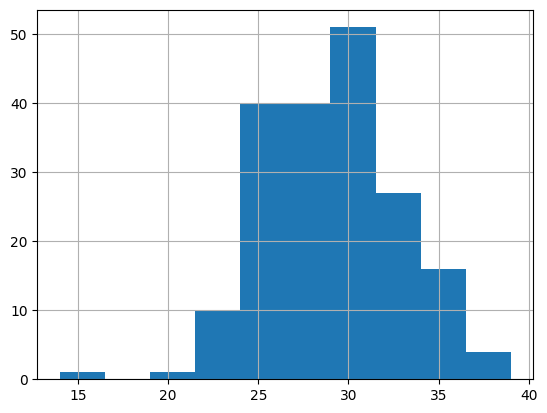

In [66]:
ds_chunk_scores['train'].to_pandas()['gpt2xl_concreteness_scores'].apply(len).hist()

<Axes: >

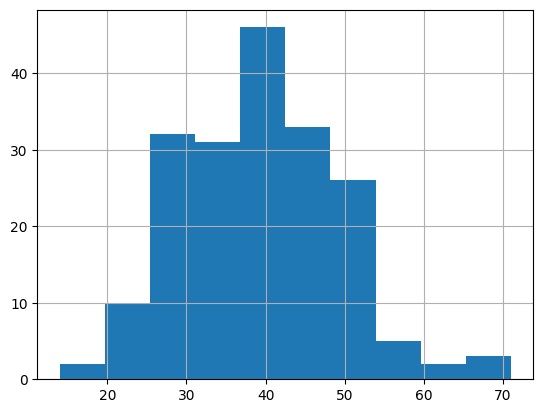

In [67]:
ds_chunk_scores['train'].to_pandas()['gpt3_mnemonic_concreteness_scores'].apply(len).hist()

<Axes: >

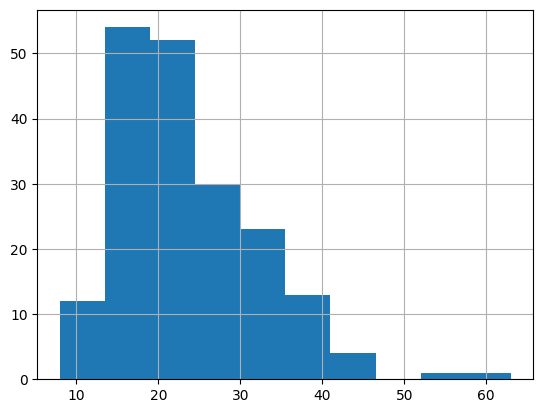

In [68]:
ds_chunk_scores['train'].to_pandas()['gpt3_paragraph_concreteness_scores'].apply(len).hist()

<Axes: >

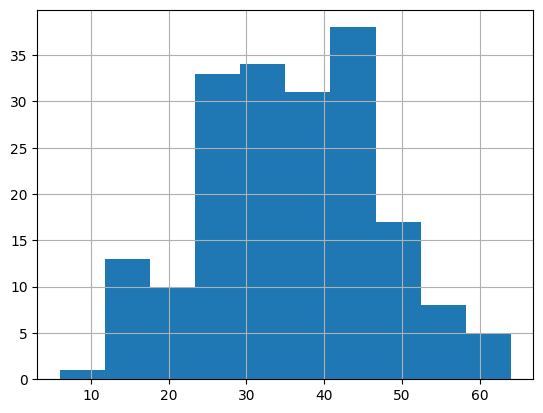

In [69]:
ds_chunk_scores['train'].to_pandas()['wanikani_concreteness_scores'].apply(len).hist()

In [70]:
ds_chunk_max = ds_chunk_scores.map(map_mean_max_n_score(1))

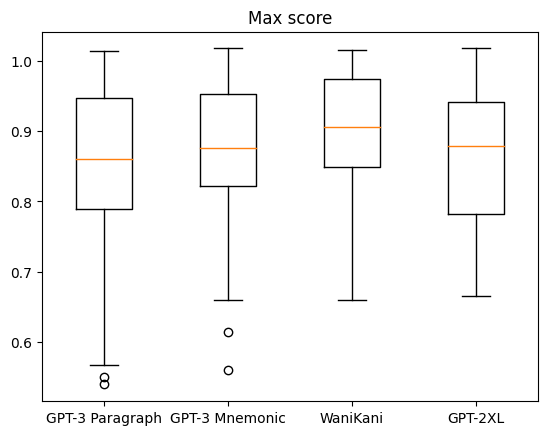

In [71]:
box_plot(ds_chunk_max['train'], 'Max score')

In [72]:
ds_chunk_5 = ds_chunk_scores.map(map_mean_max_n_score(5))

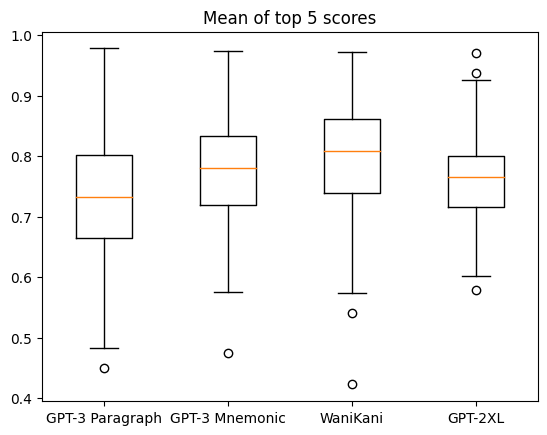

In [73]:
box_plot(ds_chunk_5['train'], 'Mean of top 5 scores')

In [74]:
anova(ds_chunk_5['train'])

p-value: 1.845910888723489e-14


In [75]:
tukey(ds_chunk_5['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.051     0.000    -0.074    -0.028
 (0 - 2)     -0.073     0.000    -0.096    -0.050
 (0 - 3)     -0.035     0.001    -0.058    -0.012
 (1 - 0)      0.051     0.000     0.028     0.074
 (1 - 2)     -0.022     0.069    -0.045     0.001
 (1 - 3)      0.016     0.284    -0.007     0.039
 (2 - 0)      0.073     0.000     0.050     0.096
 (2 - 1)      0.022     0.069    -0.001     0.045
 (2 - 3)      0.038     0.000     0.015     0.061
 (3 - 0)      0.035     0.001     0.012     0.058
 (3 - 1)     -0.016     0.284    -0.039     0.007
 (3 - 2)     -0.038     0.000    -0.061    -0.015



In [78]:
ds_chunk_80 = ds_chunk_scores.map(map_mean_max_n_score(80))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [79]:
anova(ds_chunk_80['train'])

p-value: 1.768747202841411e-05


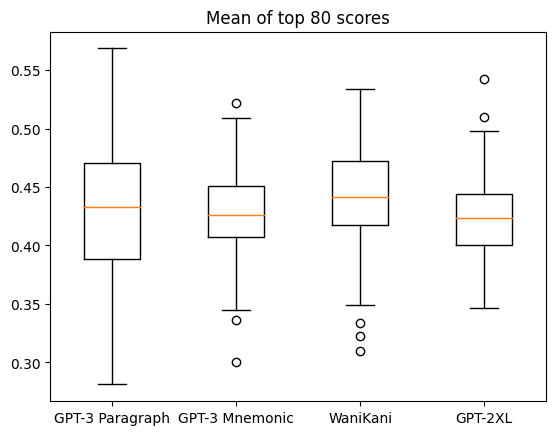

In [80]:
box_plot(ds_chunk_80['train'], 'Mean of top 80 scores')

In [81]:
tukey(ds_chunk_80['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.006     0.582    -0.006     0.017
 (0 - 2)     -0.011     0.046    -0.022    -0.000
 (0 - 3)      0.009     0.164    -0.002     0.020
 (1 - 0)     -0.006     0.582    -0.017     0.006
 (1 - 2)     -0.017     0.001    -0.028    -0.006
 (1 - 3)      0.003     0.854    -0.008     0.015
 (2 - 0)      0.011     0.046     0.000     0.022
 (2 - 1)      0.017     0.001     0.006     0.028
 (2 - 3)      0.020     0.000     0.009     0.031
 (3 - 0)     -0.009     0.164    -0.020     0.002
 (3 - 1)     -0.003     0.854    -0.015     0.008
 (3 - 2)     -0.020     0.000    -0.031    -0.009



### Conlcusion

I have made a pretty big mistake by just taking increasingly more n top scores to compute the mean. The problem here is that the length distribution of the groups is different as you can see above. So the more n scores I take into account the larger the gap between the means. But this is not likely to be due to the concreteness difference but rather because samples with smaller n get punished more as they have to inlcude all scores or increasingly bad scores. Nonetheless seem the WaniKani mnemonics outpeform the rest.